In [1]:
import random
import time
from typing import List, Literal

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import torch.nn.functional as F

%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CUDA


In [3]:
RANDOM_SEED = 42
TORCH_GENERATOR_SEED = 2147483647

random.seed(RANDOM_SEED)
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(str().join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
vocab_size = len(itos)
vocab_size

27

In [8]:
def build_dataset(words, block_size, device):
    X_data, Y_data = [], []
    for word in words:
        context = [0 for _ in range(block_size)]
        for ch in word + '.':
            ix = stoi[ch]

            X_data.append(context)
            Y_data.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X_data, device=device)
    Y = torch.tensor(Y_data, device=device)
    return X, Y

In [9]:
block_size = 3

random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_tr, Y_tr = build_dataset(words[:n1], block_size, device)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size, device)
X_te, Y_te = build_dataset(words[n2:], block_size, device)

print(f'{X_tr.shape=}, {Y_tr.shape=}\n{X_dev.shape=}, {Y_dev.shape=}\n{X_te.shape=}, {Y_te.shape=}')

X_tr.shape=torch.Size([182625, 3]), Y_tr.shape=torch.Size([182625])
X_dev.shape=torch.Size([22655, 3]), Y_dev.shape=torch.Size([22655])
X_te.shape=torch.Size([22866, 3]), Y_te.shape=torch.Size([22866])


In [10]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd),             generator=g, device=device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, device=device)
b1 = torch.randn(n_hidden,                        generator=g, device=device)
W2 = torch.randn((n_hidden, vocab_size),          generator=g, device=device)
b2 = torch.randn(vocab_size,                      generator=g, device=device)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')

Number of parameters: 11897


In [11]:
max_steps = 200_000
batch_size = 33
lr_high = 0.1
lr_low = 0.01
lossi: List[Tensor] = []

t0 = time.time()

for i in range(max_steps):
    # Get batch of data
    ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # Perform forward pass
    emb = C[Xb]                         # Embedding vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate embedding vectors
    h_pre_act = embcat @ W1 + b1        # Hidden layer pre-activation
    h = torch.tanh(h_pre_act)           # Hidden layer
    logits = h @ W2 + b2                # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss

    # Perform backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = lr_high if i < max_steps / 2 else lr_low
    for p in parameters:
        p.data += -lr * p.grad

    # Track statistics
    if i % 10_000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10())

    if i == 0:
        h_initial = h
        h_pre_act_initial = h_pre_act

lossi_cpu = [l.item() for l in lossi]

t1 = time.time()

print(f'Training took {t1 - t0} seconds')

      0 /  200000: 28.2350
  10000 /  200000: 2.9078
  20000 /  200000: 2.2068
  30000 /  200000: 2.4732
  40000 /  200000: 2.3118
  50000 /  200000: 2.9550
  60000 /  200000: 2.4715
  70000 /  200000: 2.3575
  80000 /  200000: 2.3596
  90000 /  200000: 2.1898
 100000 /  200000: 2.5135
 110000 /  200000: 1.6679
 120000 /  200000: 2.1715
 130000 /  200000: 2.2355
 140000 /  200000: 2.1209
 150000 /  200000: 2.1437
 160000 /  200000: 1.7120
 170000 /  200000: 2.2598
 180000 /  200000: 2.0292
 190000 /  200000: 2.1437
Training took 64.18842482566833 seconds


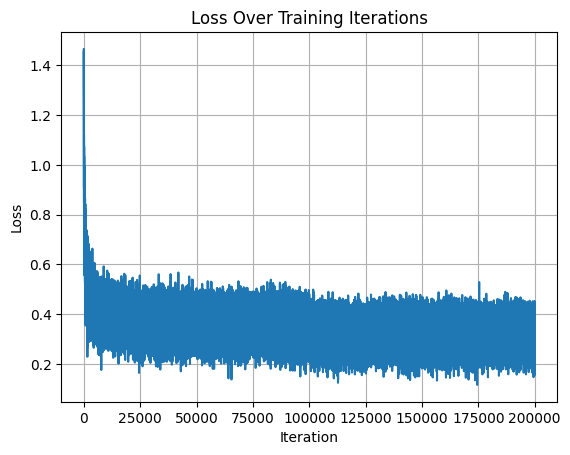

In [12]:
plt.figure()
plt.plot(lossi_cpu)
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

There is a problem with the network. Many of the values of the hidden layer are close to $-1$ or $1$. Since the derivative of $\mathrm{tanh}(x)$ is $1-\mathrm{tanh}^2(x)$, the derivative is approximately $1-1=0$, which is killing the gradient and makes the neuron learn less.

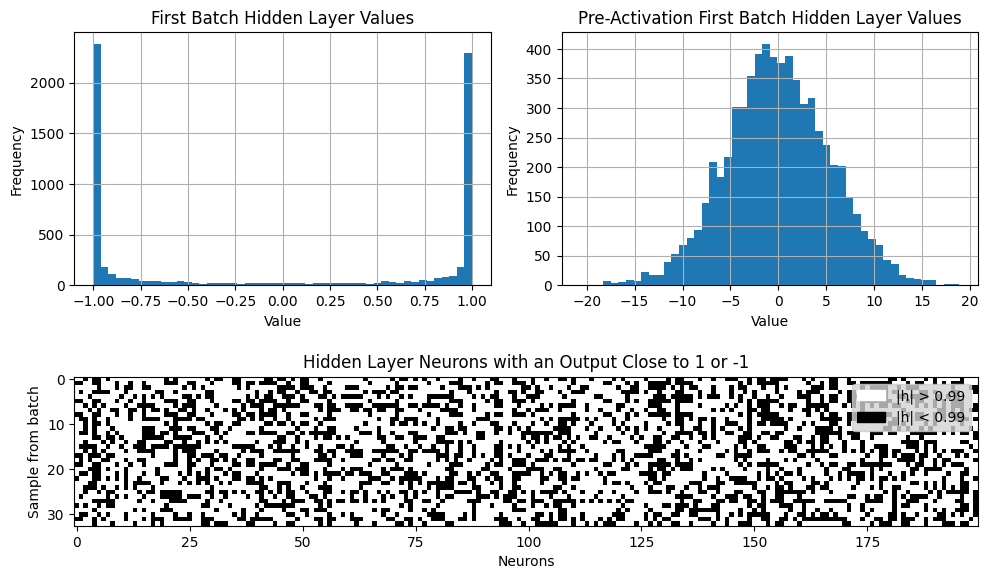

In [13]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.hist(h_initial.view(-1).tolist(), 50)
ax1.set_title('First Batch Hidden Layer Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.grid(True)

ax2.hist(h_pre_act_initial.view(-1).tolist(), 50)
ax2.set_title('Pre-Activation First Batch Hidden Layer Values')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.grid(True)

ax3.imshow((h_initial.abs() > 0.99).cpu().numpy(), cmap='grey', interpolation='nearest')
ax3.set_title('Hidden Layer Neurons with an Output Close to 1 or -1')
ax3.set_xlabel('Neurons')
ax3.set_ylabel('Sample from batch')
legend = ax3.legend(
    handles=[
        mpatches.Patch(color='white', label='|h| > 0.99'),
        mpatches.Patch(color='black', label='|h| < 0.99')
    ],
    loc='upper right'
)
legend.get_frame().set_facecolor('lightgray')

plt.tight_layout()
plt.show()

Additionally, the loss we expect on the initial iteration is $-\log\left(\frac{1}{27}\right)$. But initially it's very high (was around $27$). We can set the output bias vector to $0$ and scale down the output weights matrix to get a more uniform probability distribution.

In [14]:
-torch.tensor(1.0/27.0).log().item()

3.295836925506592

In [15]:
@torch.no_grad()
def loss_of_split(split: Literal['train'] | Literal['test'] | Literal['val']):
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_dev, Y_dev),
        'test': (X_te, Y_te)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(f'Loss of \'{split}\' split: {loss.item():.4f}')

In [16]:
loss_of_split('train')
loss_of_split('val')

Loss of 'train' split: 2.1226
Loss of 'val' split: 2.1676


In [17]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 10)

for _ in range(20):
    out = []
    context = [0 for _ in range(block_size)]

    while True:
        context_tensor = torch.tensor([context], device=device)

        emb = C[context_tensor]
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(str().join(itos[i] for i in out))

bren.
syrez.
made.
rylanjaylabrine.
breiden.
murah.
emin.
jacquad.
eweylanif.
meth.
brelloni.
adshat.
tylendelidy.
marahrann.
chilana.
deigh.
davel.
thi.
bravors.
adesterring.


Let's re-initialize the neural network to:
- bring the first weights and biases (`W1` and `b1`) closer to $0$ (to bring the hidden layer output away from the gradient-killing ends of tanh)
- bring the output weights and biases (`W2` and `b2`) closer to $0$ to reduce initial loss.

In [18]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd),             generator=g, device=device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, device=device) * 0.1
b1 = torch.randn(n_hidden,                        generator=g, device=device) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g, device=device) * 0.01
b2 = torch.randn(vocab_size,                      generator=g, device=device) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')

Number of parameters: 11897


In [19]:
max_steps = 200_000
batch_size = 33
lr_high = 0.1
lr_low = 0.01
lossi: List[Tensor] = []

t0 = time.time()

for i in range(max_steps):
    # Get batch of data
    ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # Perform forward pass
    emb = C[Xb]                         # Embedding vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate embedding vectors
    h_pre_act = embcat @ W1 + b1        # Hidden layer pre-activation
    h = torch.tanh(h_pre_act)           # Hidden layer
    logits = h @ W2 + b2                # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss

    # Perform backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = lr_high if i < max_steps / 2 else lr_low
    for p in parameters:
        p.data += -lr * p.grad

    # Track statistics
    if i % 10_000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10())

    if i == 0:
        h_initial = h
        h_pre_act_initial = h_pre_act

lossi_cpu = [l.item() for l in lossi]

t1 = time.time()

print(f'Training took {t1 - t0} seconds')

      0 /  200000: 3.2935
  10000 /  200000: 2.2926
  20000 /  200000: 2.1415
  30000 /  200000: 2.1582
  40000 /  200000: 1.9585
  50000 /  200000: 2.4733
  60000 /  200000: 2.1581
  70000 /  200000: 2.2504
  80000 /  200000: 2.1728
  90000 /  200000: 2.4179
 100000 /  200000: 2.1334
 110000 /  200000: 2.2965
 120000 /  200000: 2.1868
 130000 /  200000: 1.7542
 140000 /  200000: 1.9997
 150000 /  200000: 2.0226
 160000 /  200000: 2.0629
 170000 /  200000: 2.3499
 180000 /  200000: 1.9023
 190000 /  200000: 2.0624
Training took 63.26483201980591 seconds


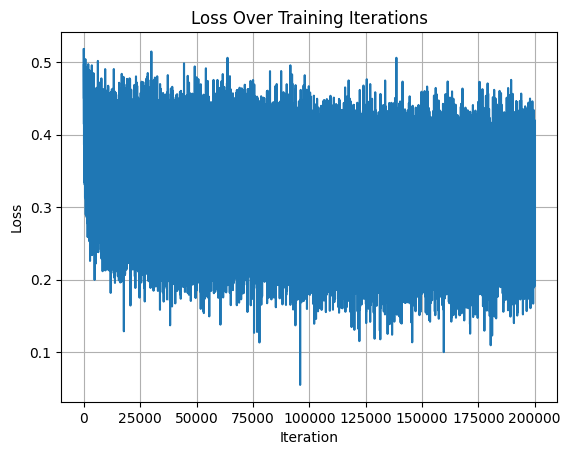

In [20]:
plt.figure()
plt.plot(lossi_cpu)
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

With the improved initial weights and biases, the initial loss is much smaller and the hidden layer values are away from the ends of tanh.

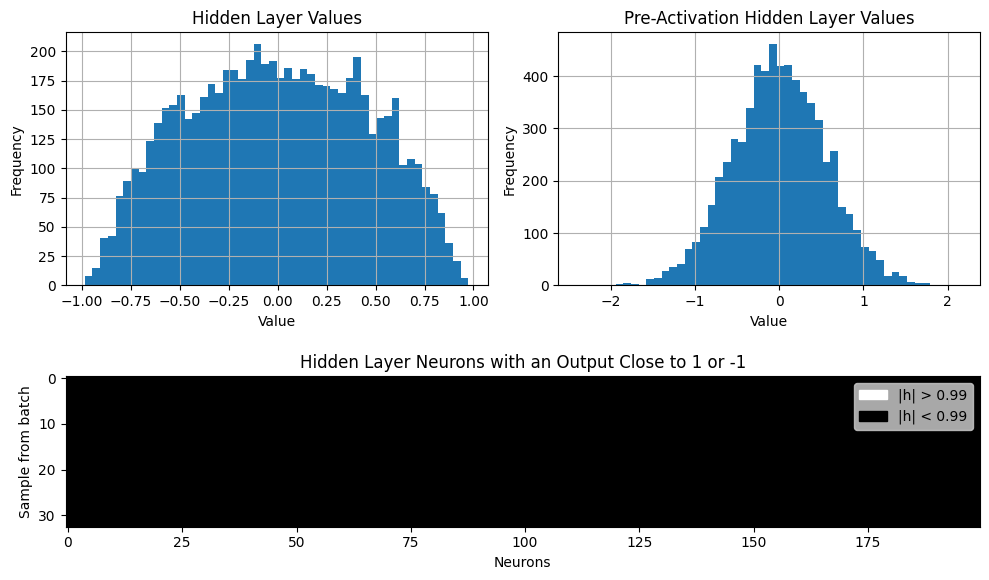

In [21]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.hist(h_initial.view(-1).tolist(), 50)
ax1.set_title('Hidden Layer Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.grid(True)

ax2.hist(h_pre_act_initial.view(-1).tolist(), 50)
ax2.set_title('Pre-Activation Hidden Layer Values')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')
ax2.grid(True)

ax3.imshow((h_initial.abs() > 0.99).cpu().numpy(), cmap='grey', interpolation='nearest')
ax3.set_title('Hidden Layer Neurons with an Output Close to 1 or -1')
ax3.set_xlabel('Neurons')
ax3.set_ylabel('Sample from batch')
legend = ax3.legend(
    handles=[
        mpatches.Patch(color='white', label='|h| > 0.99'),
        mpatches.Patch(color='black', label='|h| < 0.99')
    ],
    loc='upper right'
)
legend.get_frame().set_facecolor('lightgray')

plt.tight_layout()
plt.show()

In [22]:
loss_of_split('train')
loss_of_split('val')

Loss of 'train' split: 2.0564
Loss of 'val' split: 2.1150


In [23]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 10)

for _ in range(20):
    out = []
    context = [0 for _ in range(block_size)]

    while True:
        context_tensor = torch.tensor([context], device=device)

        emb = C[context_tensor]
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(str().join(itos[i] for i in out))

bren.
sah.
zemmaria.
kamryn.
reysley.
jeidyn.
murah.
emin.
jagton.
geory.
tain.
mel.
taylynne.
darstetaltine.
gendyn.
daz.
raan.
jullana.
dorga.
driel.


## Batch Normalization

In [24]:
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd),             generator=g, device=device)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, device=device) * 0.1
b1 = torch.randn(n_hidden,                        generator=g, device=device) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g, device=device) * 0.01
b2 = torch.randn(vocab_size,                      generator=g, device=device) * 0

bngain = torch.ones((1, n_hidden), device=device)
bnbias = torch.zeros((1, n_hidden), device=device)

bnmean_running = torch.zeros((1, n_hidden), device=device)
bnstd_running = torch.ones((1, n_hidden), device=device)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')

Number of parameters: 12297


In [25]:
max_steps = 200_000
batch_size = 33
lr_high = 0.1
lr_low = 0.01
lossi: List[Tensor] = []

t0 = time.time()

for i in range(max_steps):
    # Get batch of data
    ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = X_tr[ix], Y_tr[ix]

    # Perform forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1

    # Batch normalization
    bnmeani = h_pre_act.mean(0, keepdim=True)
    bnstdi = h_pre_act.std(0, keepdim=True)
    h_pre_act = bngain * (h_pre_act - bnmeani) / bnstdi + bnbias

    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Perform backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = lr_high if i < max_steps / 2 else lr_low
    for p in parameters:
        p.data += -lr * p.grad

    # Track statistics
    if i % 10_000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10())

    if i == 0:
        h_initial = h
        h_pre_act_initial = h_pre_act

lossi_cpu = [l.item() for l in lossi]

t1 = time.time()

print(f'Training took {t1 - t0} seconds')

      0 /  200000: 3.3055
  10000 /  200000: 2.5091
  20000 /  200000: 2.4053
  30000 /  200000: 2.2250
  40000 /  200000: 2.2063
  50000 /  200000: 2.2232
  60000 /  200000: 2.1970
  70000 /  200000: 2.3909
  80000 /  200000: 1.7101
  90000 /  200000: 2.4401
 100000 /  200000: 2.0378
 110000 /  200000: 1.9398
 120000 /  200000: 1.9652
 130000 /  200000: 2.0011
 140000 /  200000: 1.9606
 150000 /  200000: 2.0588
 160000 /  200000: 2.2116
 170000 /  200000: 1.9772
 180000 /  200000: 1.9602
 190000 /  200000: 2.0785
Training took 102.46143078804016 seconds


The batch normalization layer's mean and standard deviation can be estimated by keeping track of them during training. See below how similar they are to the actual mean and standard deviation.

In [26]:
with torch.no_grad():
    emb = C[X_tr]
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1
    bnmean = h_pre_act.mean(0, keepdim=True)
    bnstd = h_pre_act.std(0, keepdim=True)

In [27]:
bnmean - bnmean_running

tensor([[-1.0368e-02,  2.6548e-04,  2.5847e-03,  3.1774e-03,  1.9205e-02,
         -5.8312e-03,  3.7241e-03, -6.8663e-03,  5.5283e-03,  5.2161e-03,
          2.9059e-03, -4.1763e-03, -8.1587e-03, -1.3535e-02,  3.0257e-02,
         -9.8662e-03,  3.0830e-03,  1.4071e-02, -3.9810e-04, -7.4572e-03,
         -7.5057e-03,  5.7296e-03, -2.3427e-03,  1.8247e-03, -1.7977e-02,
         -1.3714e-02, -8.7544e-03,  4.5228e-03, -1.2481e-02,  1.0084e-02,
         -4.7937e-03,  5.2649e-04, -8.6915e-03,  2.0356e-03,  4.7770e-03,
         -2.8726e-03,  4.0907e-04,  6.4503e-03,  3.0670e-03, -1.5070e-03,
          3.5532e-03, -6.3293e-03,  1.0981e-02, -1.9642e-02,  8.2018e-03,
         -6.9753e-03, -7.6988e-03, -4.0958e-03,  1.2780e-02,  7.8917e-03,
         -4.7411e-03, -1.8832e-02,  3.4393e-03, -1.5817e-02,  8.3894e-03,
         -1.6853e-03,  1.0392e-02,  3.6862e-03, -4.7297e-03,  2.6907e-02,
          1.7303e-02,  9.0709e-03, -3.3304e-03, -6.1901e-03,  9.1145e-03,
          9.5672e-03, -1.3414e-02, -1.

In [28]:
bnstd - bnstd_running

tensor([[0.0185, 0.0057, 0.0127, 0.0068, 0.0124, 0.0279, 0.0152, 0.0386, 0.0221,
         0.0217, 0.0072, 0.0162, 0.0171, 0.0043, 0.0150, 0.0102, 0.0159, 0.0179,
         0.0198, 0.0312, 0.0234, 0.0038, 0.0155, 0.0111, 0.0049, 0.0215, 0.0304,
         0.0284, 0.0171, 0.0189, 0.0137, 0.0079, 0.0367, 0.0197, 0.0165, 0.0258,
         0.0167, 0.0155, 0.0182, 0.0095, 0.0256, 0.0170, 0.0097, 0.0183, 0.0161,
         0.0165, 0.0150, 0.0010, 0.0231, 0.0200, 0.0197, 0.0453, 0.0201, 0.0254,
         0.0261, 0.0259, 0.0196, 0.0098, 0.0203, 0.0227, 0.0161, 0.0121, 0.0177,
         0.0157, 0.0162, 0.0163, 0.0241, 0.0163, 0.0256, 0.0181, 0.0077, 0.0197,
         0.0129, 0.0261, 0.0084, 0.0204, 0.0094, 0.0258, 0.0077, 0.0286, 0.0130,
         0.0330, 0.0185, 0.0132, 0.0324, 0.0119, 0.0216, 0.0039, 0.0162, 0.0171,
         0.0153, 0.0193, 0.0201, 0.0115, 0.0326, 0.0200, 0.0071, 0.0196, 0.0248,
         0.0162, 0.0114, 0.0129, 0.0128, 0.0179, 0.0220, 0.0122, 0.0085, 0.0229,
         0.0144, 0.0089, 0.0

Also note that due to the batch normalization layer, the bias vector `b1` is no longer needed. This can be seen as the gradient of `b1` is approximately $0$. This means we don't need the bias in this layer (it's just a waste of CPU and RAM).

In [29]:
b1.grad

tensor([-4.6566e-10,  1.1642e-09,  4.6566e-10,  0.0000e+00, -1.8626e-09,
         0.0000e+00,  0.0000e+00, -9.3132e-10, -1.1642e-09, -1.3970e-09,
         1.5134e-09,  0.0000e+00,  1.3970e-09,  4.6566e-10, -9.3132e-10,
        -1.8626e-09, -1.6298e-09,  5.8208e-10,  4.6566e-10, -1.7462e-10,
        -9.3132e-10,  9.3132e-10,  0.0000e+00,  3.4925e-10,  6.9849e-10,
        -1.8626e-09,  0.0000e+00,  4.6566e-10,  9.3132e-10, -2.7940e-09,
         4.6566e-10, -9.3132e-10,  0.0000e+00, -4.6566e-10, -9.3132e-10,
        -4.6566e-10, -1.8626e-09,  6.9849e-10, -4.6566e-10, -3.7253e-09,
         4.6566e-10, -2.7940e-09,  0.0000e+00, -2.7940e-09, -4.6566e-09,
        -1.1642e-09, -9.3132e-10,  1.1642e-10,  2.0955e-09, -3.7253e-09,
        -2.4447e-09,  1.3970e-09,  1.6298e-09,  0.0000e+00,  0.0000e+00,
         1.3970e-09, -1.0477e-09,  0.0000e+00,  2.7940e-09,  9.3132e-10,
        -9.3132e-10,  0.0000e+00,  8.1491e-10, -9.3132e-10,  0.0000e+00,
         1.8626e-09, -5.8208e-11, -2.7940e-09,  0.0

In [30]:
@torch.no_grad()
def loss_of_split(split: Literal['train'] | Literal['test'] | Literal['val']):
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_dev, Y_dev),
        'test': (X_te, Y_te)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1
    h_pre_act = bngain * (h_pre_act - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(f'Loss of \'{split}\' split: {loss.item():.4f}')

In [31]:
loss_of_split('train')
loss_of_split('val')

Loss of 'train' split: 2.0577
Loss of 'val' split: 2.1057


In [32]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 105)

for _ in range(20):
    out = []
    context = [0 for _ in range(block_size)]

    while True:
        context_tensor = torch.tensor([context], device=device)

        emb = C[context_tensor]
        embcat = emb.view(1, -1)
        h_pre_act = embcat @ W1 + b1
        h_pre_act = bngain * (h_pre_act - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(h_pre_act)
        logits = h @ W2 + b2

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(str().join(itos[i] for i in out))

hyrarigga.
mckedina.
dylin.
stilyani.
crose.
afdhanazra.
khannie.
anorah.
alai.
ellie.
ron.
myleide.
karsherus.
reysa.
meh.
michan.
elianne.
reide.
kari.
mon.


In [48]:
from abc import ABC, abstractmethod

class Layer(ABC):
    out: Tensor | None

    @abstractmethod
    def parameters() -> List[Tensor]:
        pass

In [49]:
class Linear(Layer):

    def __init__(self, fan_in, fan_out, bias=True, generator=None, device=None):
        self.weight = torch.randn((fan_in, fan_out), generator=generator, device=device) / torch.sqrt(torch.tensor(fan_in)).item()
        self.bias = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x: Tensor):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [50]:
class BatchNorm1d(Layer):

    def __init__(self, dim, eps=1e-5, momentum=0.1, device=None):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x: Tensor):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [51]:
class Tanh(Layer):

    def __call__(self, x: Tensor):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [174]:
n_embd = 10
n_hidden = 100
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)
C = torch.randn((vocab_size, n_embd), generator=g, device=device)
layers: List[Layer] = [
    Linear(n_embd * block_size, n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, vocab_size, device=device)
]
with torch.no_grad():
    if isinstance(layers[-1], BatchNorm1d):
        layers[-1].gamma *= 0.01
    elif isinstance(layers[-1], Linear):
        layers[-1].weight *= 0.01
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5.0/3.0
parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')

Number of parameters: 46497


In [175]:
def train(layers: List[Layer], C: Tensor, X_tr: Tensor, Y_tr: Tensor, lr = 0.01, max_steps = 200_000, batch_size=32, generator=None, device=None):
    lossi = []
    ud = []
    for i in range(max_steps):
        ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=generator, device=device)
        Xb, Yb = X_tr[ix], Y_tr[ix]

        emb = C[Xb]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb)

        for layer in layers:
            if layer.out is not None:
                layer.out.retain_grad()
        for p in parameters:
            p.grad = None
        loss.backward()

        for p in parameters:
            p.data += -lr * p.grad

        if max_steps < 25 or i % int(max_steps / 25):
            print(f'Iteration: {i}/{max_steps}, Loss: {loss.item():.4f}')

        lossi.append(loss.log10())

        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    return layers, lossi, ud

In [176]:
layers, lossi, ud = train(layers, C, X_tr, Y_tr, max_steps=1000, generator=g, device=device)

Iteration: 1/1000, Loss: 3.2932
Iteration: 2/1000, Loss: 3.2927
Iteration: 3/1000, Loss: 3.2911
Iteration: 4/1000, Loss: 3.2884
Iteration: 5/1000, Loss: 3.2861
Iteration: 6/1000, Loss: 3.2806
Iteration: 7/1000, Loss: 3.2782
Iteration: 8/1000, Loss: 3.2814
Iteration: 9/1000, Loss: 3.2719
Iteration: 10/1000, Loss: 3.2821
Iteration: 11/1000, Loss: 3.2638
Iteration: 12/1000, Loss: 3.2679
Iteration: 13/1000, Loss: 3.2655
Iteration: 14/1000, Loss: 3.2614
Iteration: 15/1000, Loss: 3.2591
Iteration: 16/1000, Loss: 3.2389
Iteration: 17/1000, Loss: 3.2604
Iteration: 18/1000, Loss: 3.2305
Iteration: 19/1000, Loss: 3.2422
Iteration: 20/1000, Loss: 3.2621
Iteration: 21/1000, Loss: 3.2710
Iteration: 22/1000, Loss: 3.2327
Iteration: 23/1000, Loss: 3.2320
Iteration: 24/1000, Loss: 3.2079
Iteration: 25/1000, Loss: 3.2477
Iteration: 26/1000, Loss: 3.2437
Iteration: 27/1000, Loss: 3.2200
Iteration: 28/1000, Loss: 3.2441
Iteration: 29/1000, Loss: 3.2310
Iteration: 30/1000, Loss: 3.2332
Iteration: 31/1000,

Layer 1 (tanh), mean: 0.0638, std: 0.7552, saturated: 21.71875
Layer 3 (tanh), mean: -0.0188, std: 0.6913, saturated: 9.999999046325684
Layer 5 (tanh), mean: -0.0337, std: 0.6721, saturated: 6.781249523162842
Layer 7 (tanh), mean: 0.0102, std: 0.6896, saturated: 7.406249523162842
Layer 9 (tanh), mean: -0.0689, std: 0.6960, saturated: 10.09375


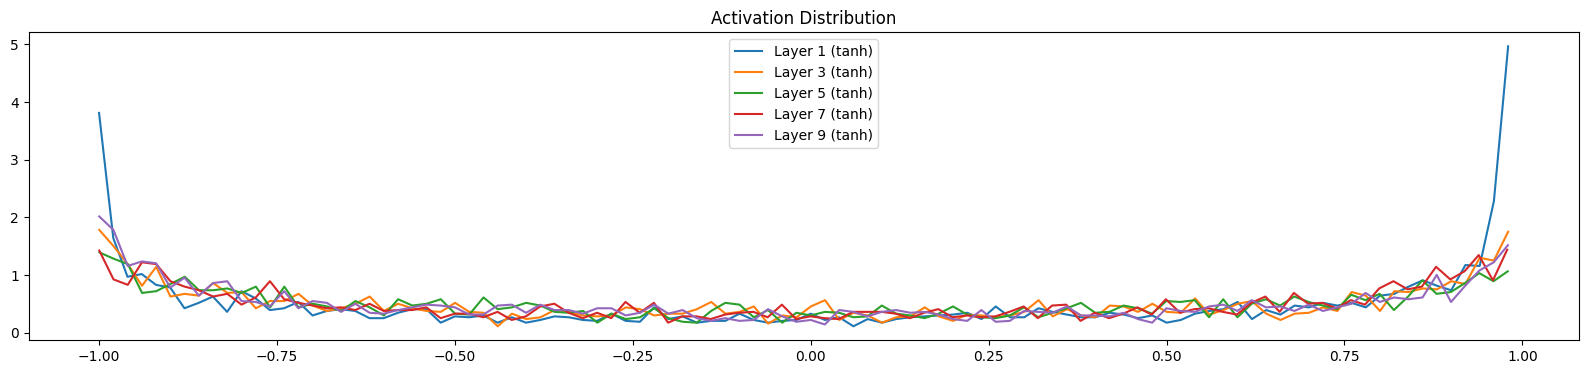

In [177]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'Layer {i} (tanh), mean: {t.mean():.4f}, std: {t.std():.4f}, saturated: {(t.abs() > 0.97).float().mean()*100}')
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} (tanh)')
plt.legend(legends)
plt.title('Activation Distribution')
plt.show()

Layer 1 (tanh), mean: -0.0000, std: 0.0026, saturated: 0.0
Layer 3 (tanh), mean: -0.0000, std: 0.0023, saturated: 0.0
Layer 5 (tanh), mean: 0.0001, std: 0.0020, saturated: 0.0
Layer 7 (tanh), mean: 0.0000, std: 0.0016, saturated: 0.0
Layer 9 (tanh), mean: 0.0000, std: 0.0012, saturated: 0.0


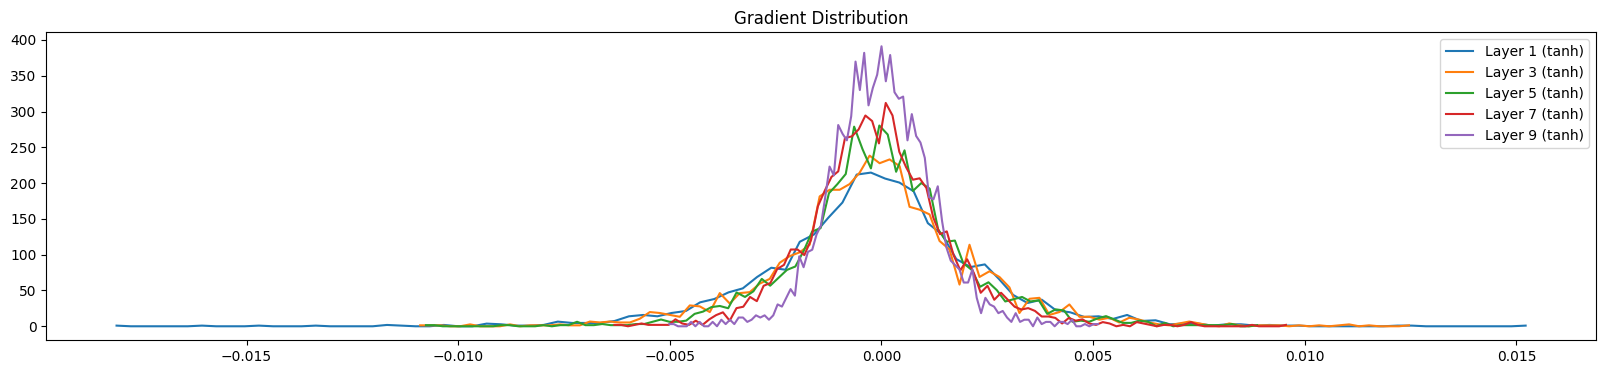

In [178]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'Layer {i} (tanh), mean: {t.mean():.4f}, std: {t.std():.4f}, saturated: {(t.abs() > 0.97).float().mean()*100}')
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} (tanh)')
plt.legend(legends)
plt.title('Gradient Distribution')
plt.show()

Weight torch.Size([27, 10]), mean: -0.0002, std: 0.0101, grad:data ratio: 0.009907747618854046
Weight torch.Size([30, 100]), mean: 0.0002, std: 0.0083, grad:data ratio: 0.026924479752779007
Weight torch.Size([100, 100]), mean: 0.0000, std: 0.0065, grad:data ratio: 0.038936495780944824
Weight torch.Size([100, 100]), mean: -0.0001, std: 0.0055, grad:data ratio: 0.03270209580659866
Weight torch.Size([100, 100]), mean: 0.0001, std: 0.0039, grad:data ratio: 0.023325469344854355
Weight torch.Size([100, 100]), mean: -0.0000, std: 0.0028, grad:data ratio: 0.01649254560470581
Weight torch.Size([100, 27]), mean: 0.0000, std: 0.0199, grad:data ratio: 0.6062183976173401


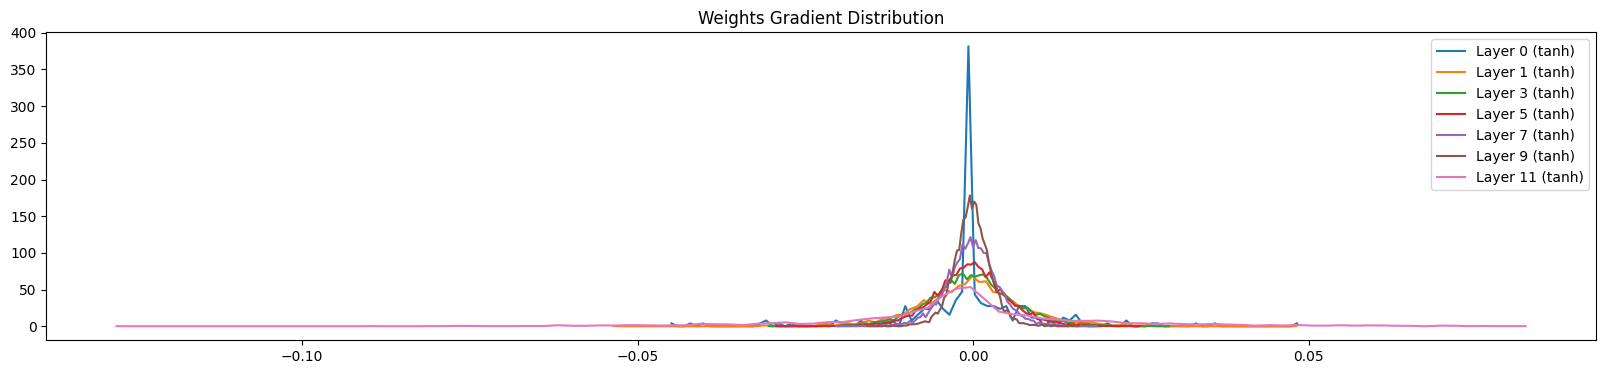

In [179]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(f'Weight {p.shape}, mean: {t.mean():.4f}, std: {t.std():.4f}, grad:data ratio: {t.std() / p.std()}')
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} (tanh)')
plt.legend(legends)
plt.title('Weights Gradient Distribution')
plt.show()

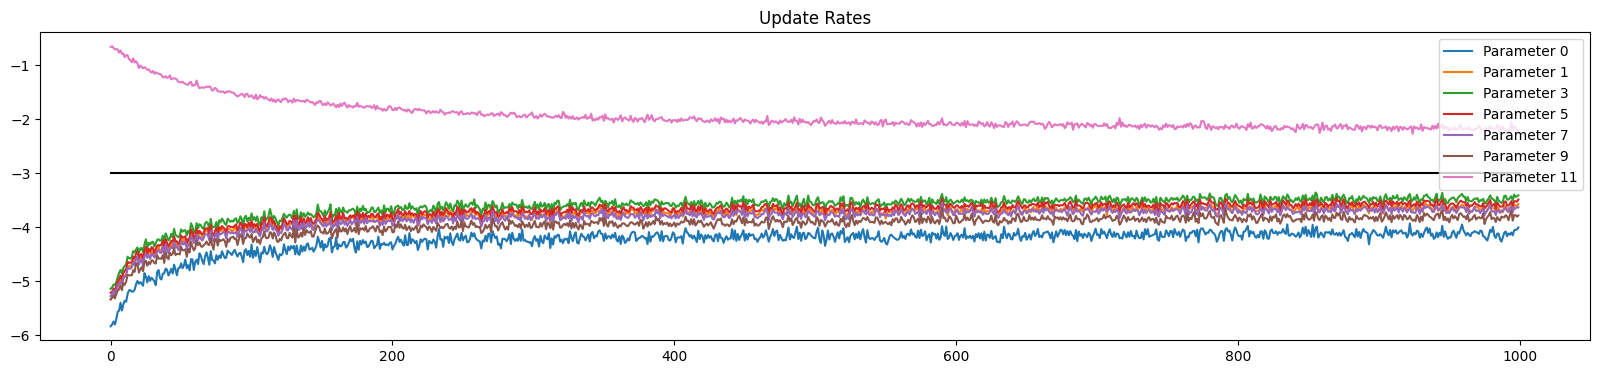

In [180]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'Parameter {i}')
plt.legend(legends)
plt.title('Update Rates')
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.show()

In [181]:
n_embd = 10
n_hidden = 100
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)
C = torch.randn((vocab_size, n_embd), generator=g, device=device)
layers: List[Layer] = [
    Linear(n_embd * block_size, n_hidden, bias=False, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, bias=False, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, vocab_size, bias=False, device=device),
    BatchNorm1d(vocab_size, device=device)
]
with torch.no_grad():
    if isinstance(layers[-1], BatchNorm1d):
        layers[-1].gamma *= 0.1
    elif isinstance(layers[-1], Linear):
        layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0
parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
print(f'Number of parameters: {sum(p.nelement() for p in parameters)}')

Number of parameters: 47024


In [182]:
layers, lossi, ud = train(layers, C, X_tr, Y_tr, max_steps=1000, generator=g, device=device)

Iteration: 1/1000, Loss: 3.3175
Iteration: 2/1000, Loss: 3.3141
Iteration: 3/1000, Loss: 3.2956
Iteration: 4/1000, Loss: 3.3305
Iteration: 5/1000, Loss: 3.3069
Iteration: 6/1000, Loss: 3.2877
Iteration: 7/1000, Loss: 3.2829
Iteration: 8/1000, Loss: 3.3104
Iteration: 9/1000, Loss: 3.3132
Iteration: 10/1000, Loss: 3.2636
Iteration: 11/1000, Loss: 3.3231
Iteration: 12/1000, Loss: 3.2820
Iteration: 13/1000, Loss: 3.3126
Iteration: 14/1000, Loss: 3.2872
Iteration: 15/1000, Loss: 3.3070
Iteration: 16/1000, Loss: 3.3190
Iteration: 17/1000, Loss: 3.3134
Iteration: 18/1000, Loss: 3.3071
Iteration: 19/1000, Loss: 3.2771
Iteration: 20/1000, Loss: 3.3015
Iteration: 21/1000, Loss: 3.3049
Iteration: 22/1000, Loss: 3.2991
Iteration: 23/1000, Loss: 3.3113
Iteration: 24/1000, Loss: 3.3151
Iteration: 25/1000, Loss: 3.2711
Iteration: 26/1000, Loss: 3.2944
Iteration: 27/1000, Loss: 3.2932
Iteration: 28/1000, Loss: 3.2838
Iteration: 29/1000, Loss: 3.2896
Iteration: 30/1000, Loss: 3.2904
Iteration: 31/1000,

Layer 2 (tanh), mean: -0.0053, std: 0.6322, saturated: 3.3750%
Layer 5 (tanh), mean: 0.0014, std: 0.6355, saturated: 2.9062%
Layer 8 (tanh), mean: 0.0005, std: 0.6401, saturated: 2.4688%
Layer 11 (tanh), mean: 0.0022, std: 0.6407, saturated: 2.2188%
Layer 14 (tanh), mean: 0.0004, std: 0.6363, saturated: 2.7188%


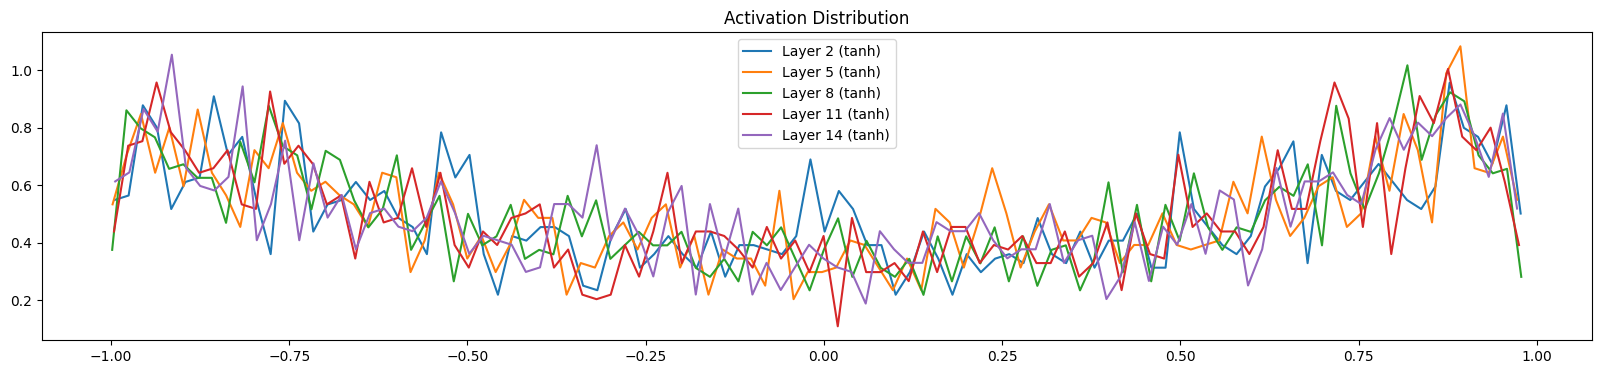

In [183]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'Layer {i} (tanh), mean: {t.mean():.4f}, std: {t.std():.4f}, saturated: {(t.abs() > 0.97).float().mean()*100:.4f}%')
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} (tanh)')
plt.legend(legends)
plt.title('Activation Distribution')
plt.show()

Layer 2 (tanh), mean: -0.0000, std: 0.0023, saturated: 0.0
Layer 5 (tanh), mean: 0.0000, std: 0.0020, saturated: 0.0
Layer 8 (tanh), mean: -0.0000, std: 0.0018, saturated: 0.0
Layer 11 (tanh), mean: -0.0000, std: 0.0017, saturated: 0.0
Layer 14 (tanh), mean: 0.0000, std: 0.0014, saturated: 0.0


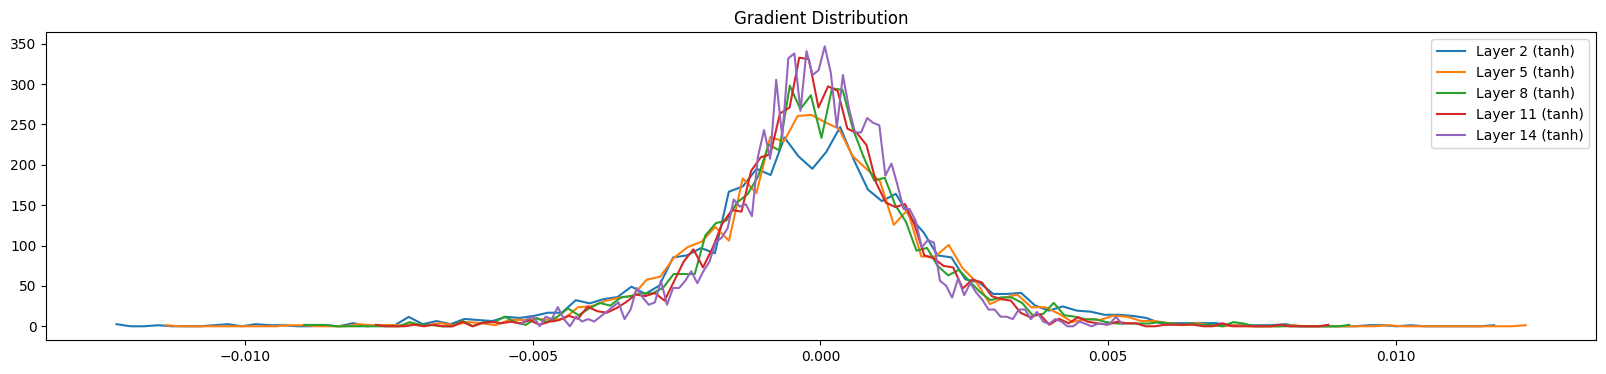

In [184]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'Layer {i} (tanh), mean: {t.mean():.4f}, std: {t.std():.4f}, saturated: {(t.abs() > 0.97).float().mean()*100}')
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} (tanh)')
plt.legend(legends)
plt.title('Gradient Distribution')
plt.show()

Weight torch.Size([27, 10]), mean: -0.0000, std: 0.0051, grad:data ratio: 0.00501613924279809
Weight torch.Size([30, 100]), mean: 0.0001, std: 0.0090, grad:data ratio: 0.04887266829609871
Weight torch.Size([100, 100]), mean: 0.0000, std: 0.0081, grad:data ratio: 0.08101937174797058
Weight torch.Size([100, 100]), mean: 0.0002, std: 0.0071, grad:data ratio: 0.07072228938341141
Weight torch.Size([100, 100]), mean: -0.0000, std: 0.0069, grad:data ratio: 0.06955868005752563
Weight torch.Size([100, 100]), mean: -0.0002, std: 0.0057, grad:data ratio: 0.0567694753408432
Weight torch.Size([100, 27]), mean: 0.0000, std: 0.0097, grad:data ratio: 0.09944995492696762


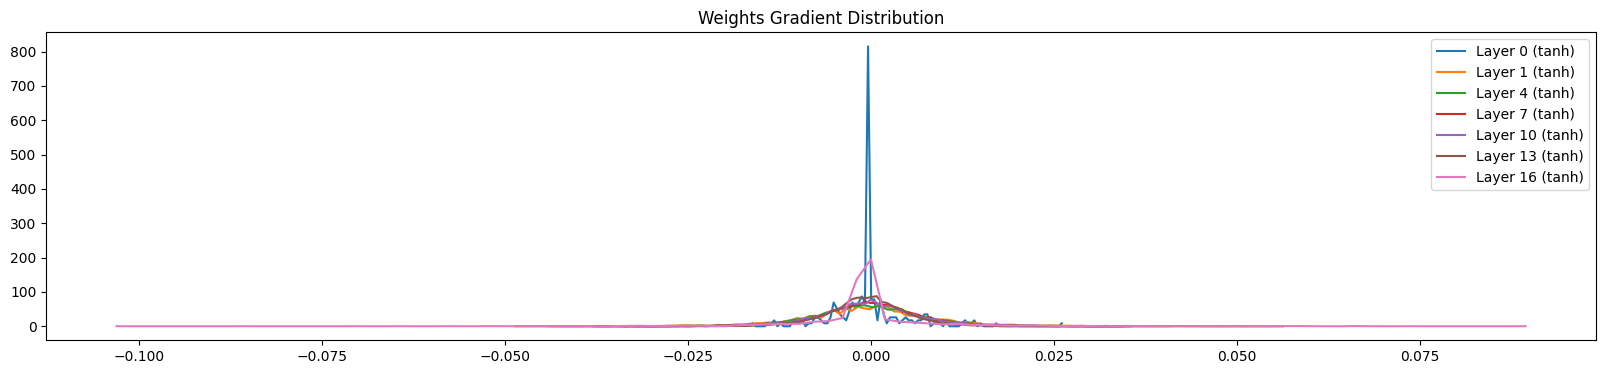

In [185]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(f'Weight {p.shape}, mean: {t.mean():.4f}, std: {t.std():.4f}, grad:data ratio: {t.std() / p.std()}')
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} (tanh)')
plt.legend(legends)
plt.title('Weights Gradient Distribution')
plt.show()

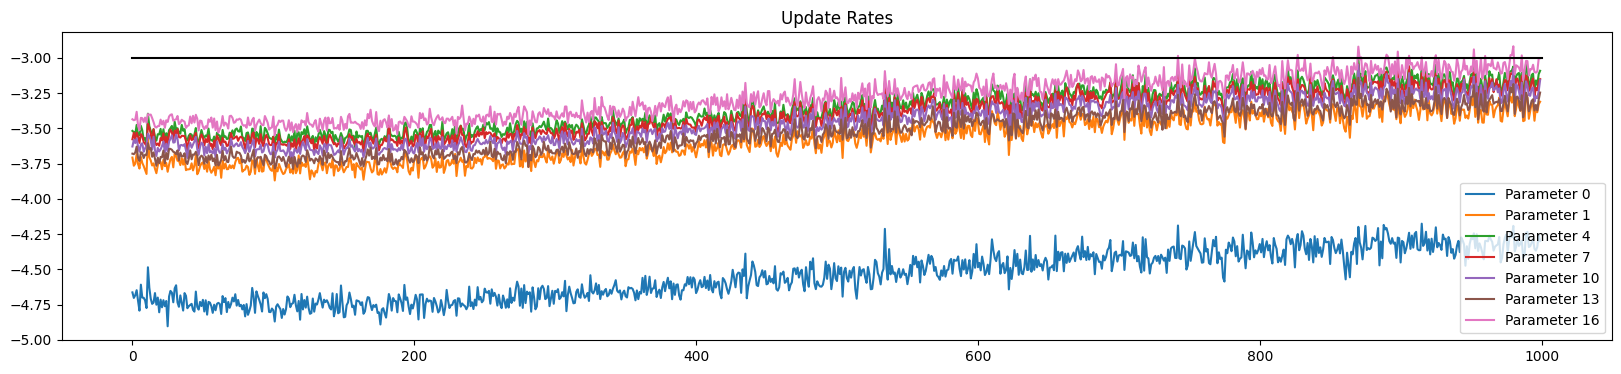

In [186]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'Parameter {i}')
plt.legend(legends)
plt.title('Update Rates')
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.show()